# Deblending

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from scipy.sparse.linalg import lobpcg as sp_lobpcg
from scipy.signal import convolve, filtfilt
from pylops                            import LinearOperator
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.signalprocessing.patch2d   import patch2d_design
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import fista
from pylops.waveeqprocessing.blending  import *
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.describe             import describe

np.random.seed(10)

parallel True


Load the data and create two datasets:

- OBC for group and half
- Streamer for continous

In [2]:
inputdata = np.load("../data/marchenko/input.npz")
data = inputdata['R']
data = np.pad(data, ((0,0), (0,0), (0,32)))
wav = inputdata['wav']
wav_c = np.argmax(wav)

ns, nr, nt = data.shape

# time axis
dt = 0.004
t =  np.arange(nt) * dt

# convolve with wavelet
data = np.apply_along_axis(convolve, -1, data, wav, mode='full')
data = data[...,wav_c:][...,:nt]

(96, 96, 832)
(99, 99, 832)


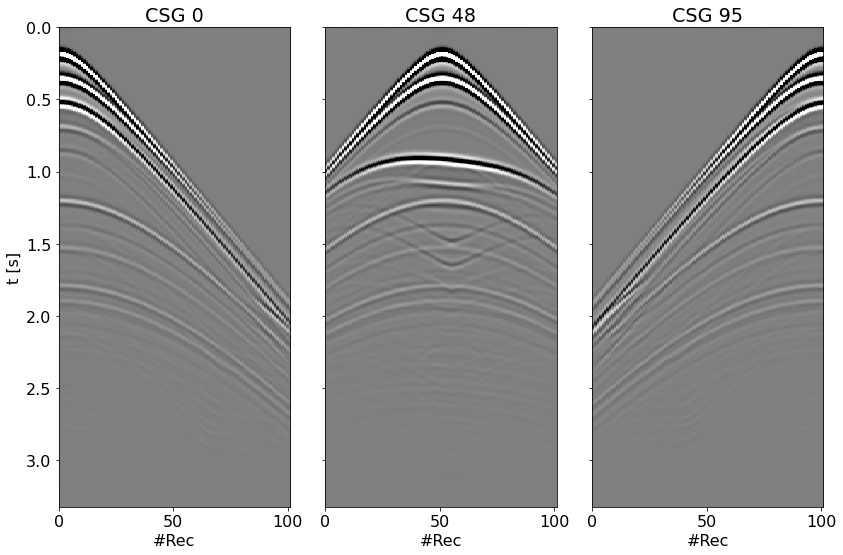

In [3]:
# obc 
data_obc = data[:96, :96]
ns_obc, nr_obc, _ = data_obc.shape
print(data_obc.shape)

# obc 
data_obc3 = data[:-2, :-2]
ns_obc3, nr_obc3, _ = data_obc3.shape
print(data_obc3.shape)

# visualize
isrcplot = [0, ns_obc//2, ns_obc-1]
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 8))
for i, ax in enumerate(axs):
    ax.imshow(data_obc[isrcplot[i]].T, cmap="gray",
              vmin=-.1, vmax=.1,
              extent=(0, nr, t[-1], 0),
              interpolation="none",)
    ax.set_title(f"CSG {isrcplot[i]}")
    ax.set_xlabel("#Rec")
    ax.axis("tight")
axs[0].set_ylabel("t [s]")
plt.tight_layout();

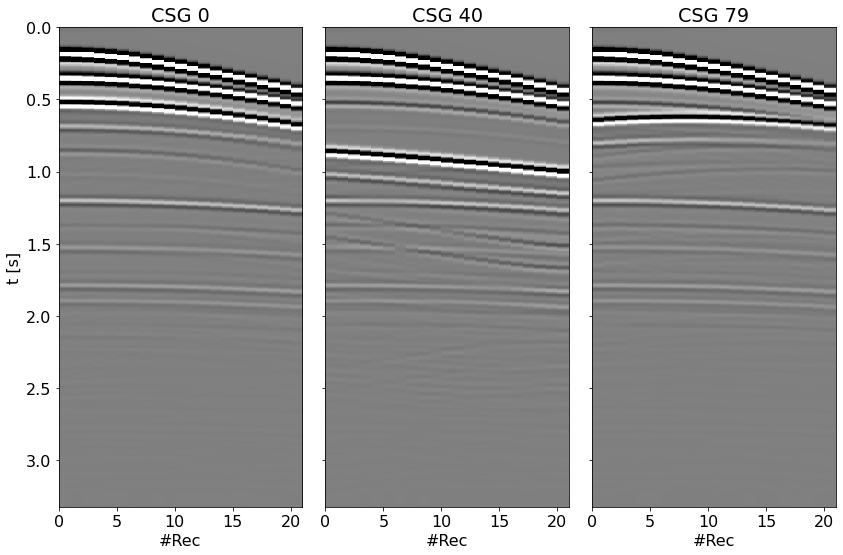

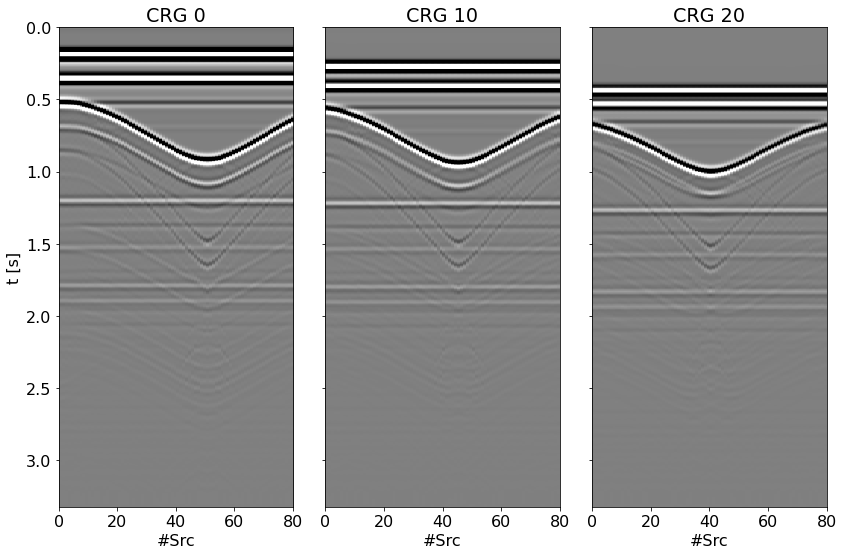

In [4]:
# data streamer
nr_stremer = 21
ns_stremer = ns - nr_stremer

data_streamer = np.zeros((ns_stremer, nr_stremer, nt))
for isrc in range(ns_stremer):
    data_streamer[isrc] = data[isrc, isrc:isrc+nr_stremer]

# visualize
isrcplot = [0, ns_stremer//2, ns_stremer-1]
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 8))
for i, ax in enumerate(axs):
    ax.imshow(data_streamer[isrcplot[i]].T, cmap="gray",
              vmin=-.1, vmax=.1,
              extent=(0, nr_stremer, t[-1], 0),
              interpolation="none")
    ax.set_title(f"CSG {isrcplot[i]}")
    ax.set_xlabel("#Rec")
    ax.axis("tight")
axs[0].set_ylabel("t [s]")
plt.tight_layout();

irecplot = [0, nr_stremer//2, nr_stremer-1]
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 8))
for i, ax in enumerate(axs):
    ax.imshow(data_streamer[:, irecplot[i]].T, cmap="gray",
              vmin=-.1, vmax=.1,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
    ax.set_title(f"CRG {irecplot[i]}")
    ax.set_xlabel("#Src")
    ax.axis("tight")
axs[0].set_ylabel("t [s]")
plt.tight_layout();

## Continuous blending

[ 1.3315865   0.71527897 -1.54540029 -0.00838385  0.62133597 -0.72008556
  0.26551159  0.10854853  0.00429143 -0.17460021  0.43302619  1.20303737
 -0.96506567  1.02827408  0.22863013  0.44513761 -1.13660221  0.13513688
  1.484537   -1.07980489 -1.97772828 -1.7433723   0.26607016  2.38496733
  1.12369125  1.67262221  0.09914922  1.39799638 -0.27124799  0.61320418
 -0.26731719 -0.54930901  0.1327083  -0.47614201  1.30847308  0.19501328
  0.40020999 -0.33763234  1.25647226 -0.7319695   0.66023155 -0.35087189
 -0.93943336 -0.48933722 -0.80459114 -0.21269764 -0.33914025  0.31216994
  0.56515267 -0.14742026 -0.02590534  0.2890942  -0.53987907  0.70816002
  0.84222474  0.2035808   2.39470366  0.91745894 -0.11227247 -0.36218045
 -0.23218226 -0.5017289   1.12878515 -0.69781003 -0.08112218 -0.52929608
  1.04618286 -1.41855603 -0.36249918 -0.12190569  0.31935642  0.4609029
 -0.21578989  0.98907246  0.31475378  2.46765106 -1.50832149  0.62060066
 -1.04513254 -0.79800882]
ignition_times [0.        

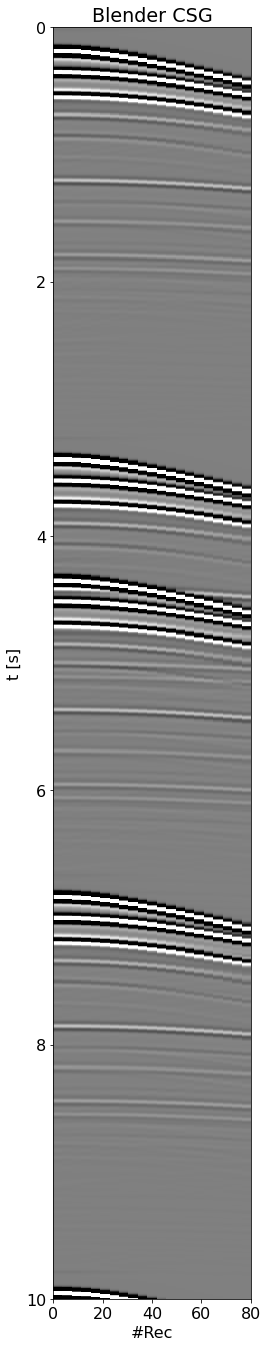

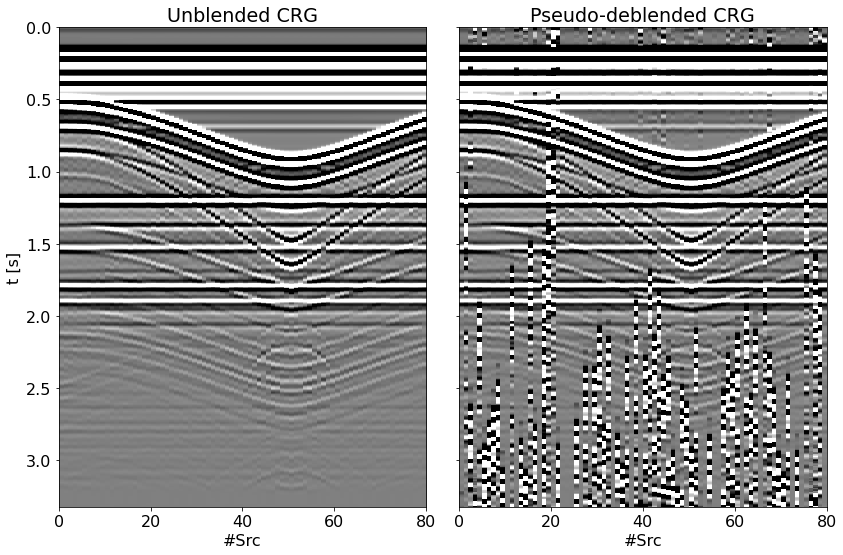

In [5]:
overlap = 0.25
ignition_times = np.random.normal(0, 1., ns_stremer)
print(ignition_times)
ignition_times += (1-overlap) * nt * dt
ignition_times[0] = 0.
print('ignition_times', ignition_times)

# Blending
Bop = BlendingContinuous(nt, nr_stremer, ns_stremer, dt, np.cumsum(ignition_times), dtype="complex128")
dottest(Bop, verb=True)
data_blended = Bop * data_streamer
data_pseudo = Bop.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(4, 19))
ax.imshow(data_blended.real.T, cmap="gray",
          vmin=-.1, vmax=.1,
          extent=(0, ns_stremer, Bop.nttot*dt, 0),
          interpolation="none")
ax.set_title("Blender CSG")
ax.set_xlabel("#Rec")
ax.set_ylabel("t [s]")
ax.axis("tight")
ax.set_ylim(10, 0)
plt.tight_layout()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 8))
axs[0].imshow(data_streamer[:, 0].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[0].set_title("Unblended CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(data_pseudo[:, 0].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
plt.tight_layout()

 576 608 640 672 704 736 768], end:[ 64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576 608
 640 672 704 736 768 800 832]
  910  975 1040 1105 1170 1235 1300 1365 1430 1495 1560], end:[  65  130  195  260  325  390  455  520  585  650  715  780  845  910
  975 1040 1105 1170 1235 1300 1365 1430 1495 1560 1625]


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 52114 rows and 832000 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 100
alpha = 3.343254e-01	thresh = 1.671627e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   1.17e-02+0.00e+00j    1.174e+02   1.331e+02   7.490e+00
     2   3.04e-02+0.00e+00j    6.425e+01   8.871e+01   4.465e+00
     3   5.44e-02+0.00e+00j    3.463e+01   6.587e+01   3.750e+00
     4   8.07e-02+0.00e+00j    1.900e+01   5.492e+01   3.016e+00
     5   1.07e-01+0.00e+00j    1.063e+01   4.935e+01   2.433e+00
     6   1.32e-01+0.00e+00j    6.003e+00   4.609e+01   2.004e+00
     7   1.55e-01+0.00e+00j    3.413e+00   4.382e+01   1.685e+00
     8   1.76e-01+0.00e+00j    1.977e+00   4.203e+01   1.440e+00
     9   1.96e-01+0.00e+00j    1.202e+00   4.048e+01   1.249e+00
    10   2.13e-01+0.00

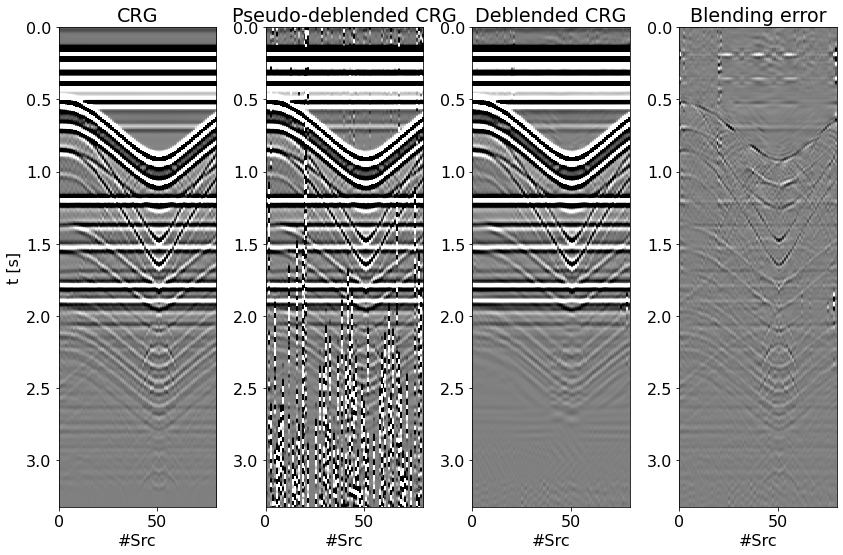

In [6]:
# Deblending
dimsd = (ns_stremer, nt)
nwin = (32, 64)
nover = (16, 32)
nop = (128, 128)
nop1 = (128, 65)

Fop = FFT2D(nwin, nffts=nop, real=True)
nwins, dims, _, _ = patch2d_design(dimsd, nwin, nover, nop1)
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning")
Sop1 = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1, tapertype=None)
Bop = BlendingContinuous(nt, 1, ns_stremer, dt, np.cumsum(ignition_times), dtype="complex128")

# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 100
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

p_inv = fista(
    Op,
    data_blended[0],
    niter=niter,
    eps=1e-2,
    alpha=alpha,
    decay=decay,
    show=True,
)[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns_stremer, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(
    data_streamer[:, 0].T.real,
    cmap="gray",
    extent=(0, ns_stremer, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(
    data_pseudo[:, 0].T.real,
    cmap="gray",
    extent=(0, ns_stremer, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(
    data_inv.T.real,
    cmap="gray",
    extent=(0, ns_stremer, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(
    data_streamer[:, 0].T.real - data_inv.T.real,
    cmap="gray",
    extent=(0, ns_stremer, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

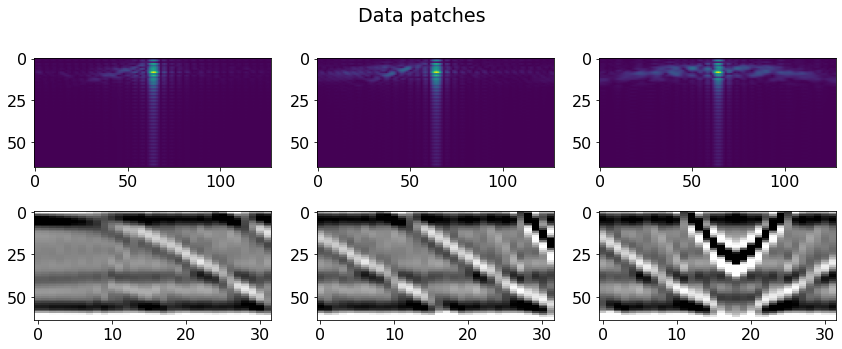

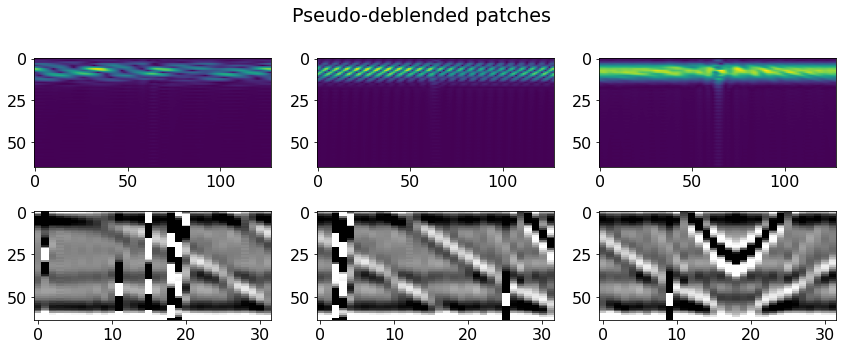

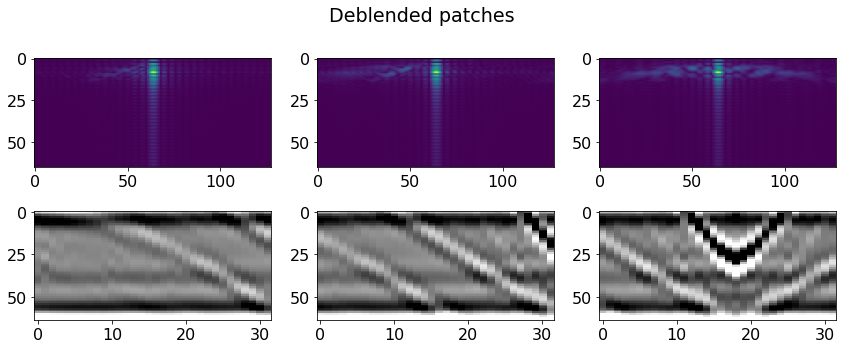

In [7]:
# Original
p = Sop1.H * data_streamer[:, 0].ravel()
preshape = p.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

it = 12
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Data patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(preshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * preshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Pseudo-deblended
p_pseudo = Sop1.H * data_pseudo[:, 0].ravel()
p_pseudoreshape = p_pseudo.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Pseudo-deblended patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_pseudoreshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_pseudoreshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Deblended
p_inv = Sop1.H * data_inv.ravel()
p_invreshape = p_inv.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Deblended patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_invreshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_invreshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout();

Let's just blend one receiver

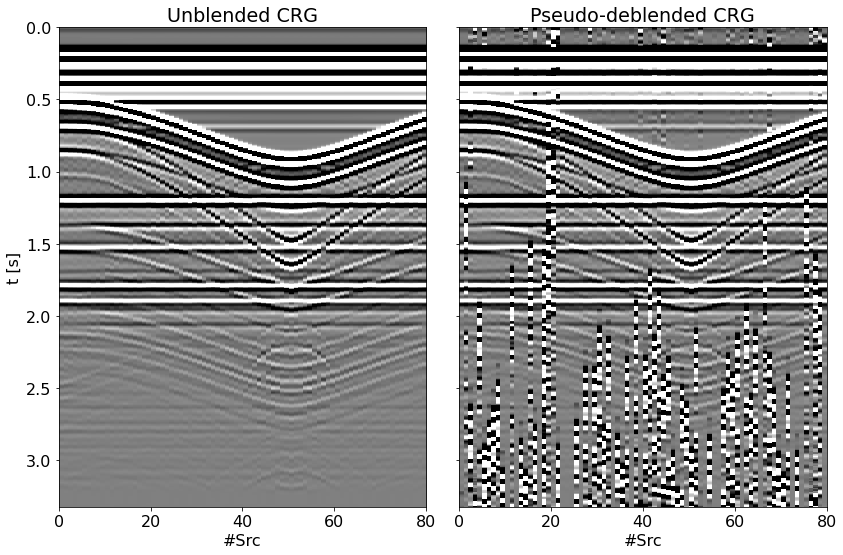

In [8]:
# Blending
Bop = BlendingContinuous(nt, 1, ns_stremer, dt, np.cumsum(ignition_times), dtype="complex128")

data_blended = Bop * data_streamer[:, 0].ravel()
data_pseudo = Bop.H * data_blended.ravel()

ntblended = int(np.sum(Bop.times) / Bop.dt + Bop.nt + 1)
data_pseudo = data_pseudo.reshape(ns_stremer, nt)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 8))
axs[0].imshow(data_streamer[:, 0].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[0].set_title("Unblended CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(data_pseudo.real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
plt.tight_layout()

 576 608 640 672 704 736 768], end:[ 64  96 128 160 192 224 256 288 320 352 384 416 448 480 512 544 576 608
 640 672 704 736 768 800 832]
  910  975 1040 1105 1170 1235 1300 1365 1430 1495 1560], end:[  65  130  195  260  325  390  455  520  585  650  715  780  845  910
  975 1040 1105 1170 1235 1300 1365 1430 1495 1560 1625]


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 52114 rows and 832000 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 100
alpha = 3.288900e-01	thresh = 1.644450e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   1.15e-02+0.00e+00j    1.191e+02   1.346e+02   7.368e+00
     2   2.98e-02+0.00e+00j    6.565e+01   8.982e+01   4.438e+00
     3   5.34e-02+0.00e+00j    3.553e+01   6.652e+01   3.749e+00
     4   7.94e-02+0.00e+00j    1.956e+01   5.529e+01   3.025e+00
     5   1.05e-01+0.00e+00j    1.098e+01   4.960e+01   2.442e+00
     6   1.30e-01+0.00e+00j    6.221e+00   4.628e+01   2.012e+00
     7   1.54e-01+0.00e+00j    3.546e+00   4.400e+01   1.692e+00
     8   1.75e-01+0.00e+00j    2.056e+00   4.220e+01   1.446e+00
     9   1.94e-01+0.00e+00j    1.246e+00   4.065e+01   1.253e+00
    10   2.11e-01+0.00

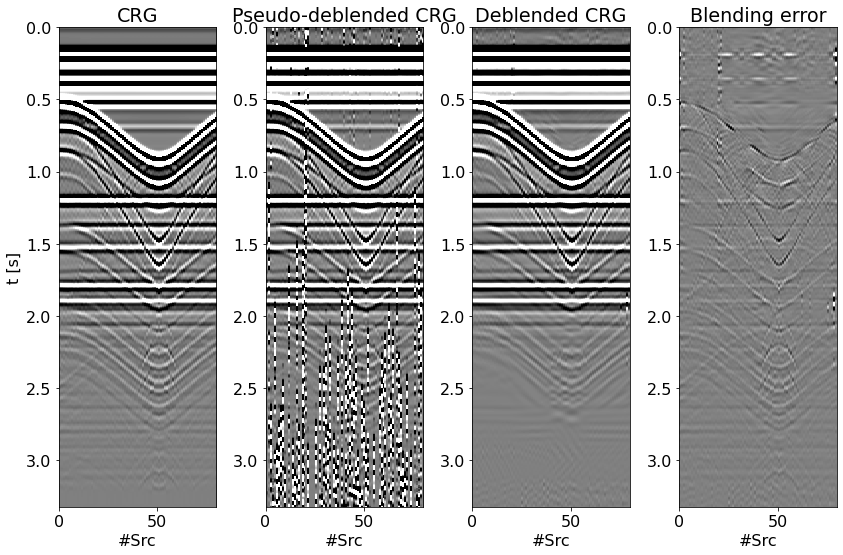

In [9]:
# Deblending
dimsd = (ns_stremer, nt)
nwin = (32, 64)
nover = (16, 32)
nop = (128, 128)
nop1 = (128, 65)

Fop = FFT2D(nwin, nffts=nop, real=True)
nwins, dims, _, _ = patch2d_design(dimsd, nwin, nover, nop1)
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning")
Sop1 = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1, tapertype=None)

# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 100
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

p_inv = fista(
    Op,
    data_blended,
    niter=niter,
    eps=1e-2,
    alpha=alpha,
    decay=decay,
    show=True,
)[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns_stremer, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(
    data_streamer[:, 0].T.real,
    cmap="gray",
    extent=(0, ns_stremer, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(
    data_pseudo.T.real,
    cmap="gray",
    extent=(0, ns_stremer, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(
    data_inv.T.real,
    cmap="gray",
    extent=(0, ns_stremer, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(
    data_streamer[:, 0].T.real - data_inv.T.real,
    cmap="gray",
    extent=(0, ns_stremer, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

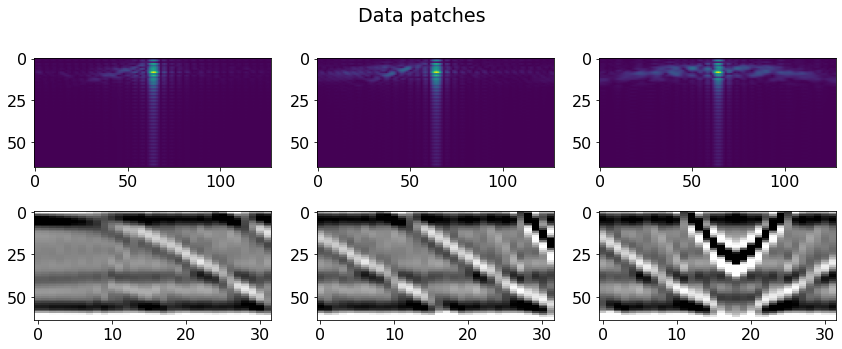

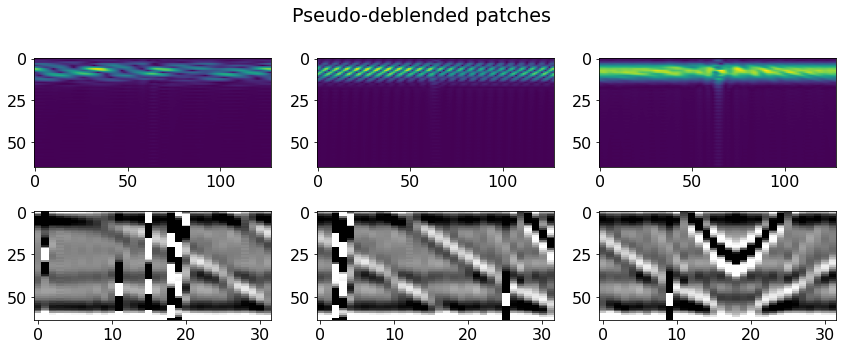

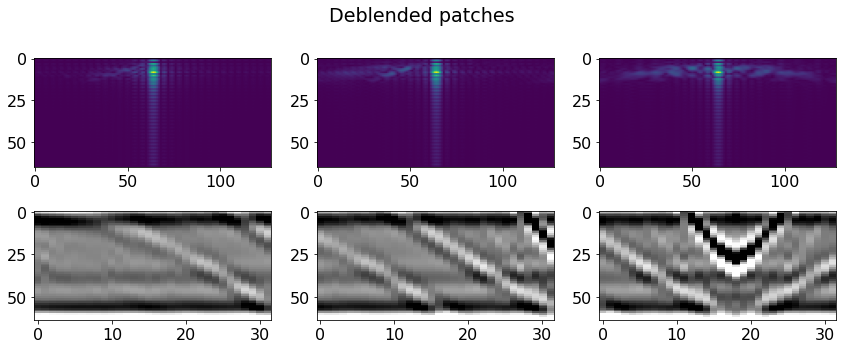

In [10]:
# Original
p = Sop1.H * data_streamer[:, 0].ravel()
preshape = p.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

it = 12
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Data patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(preshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * preshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Pseudo-deblended
p_pseudo = Sop1.H * data_pseudo.ravel()
p_pseudoreshape = p_pseudo.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Pseudo-deblended patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_pseudoreshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_pseudoreshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Deblended
p_inv = Sop1.H * data_inv.ravel()
p_invreshape = p_inv.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Deblended patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_invreshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_invreshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

## Group blending

Dot test passed, v^H(Opu)=(-1914.910728381026+105.83476924969376j) - u^H(Op^Hv)=(-1914.910728381072+105.83476924968878j)


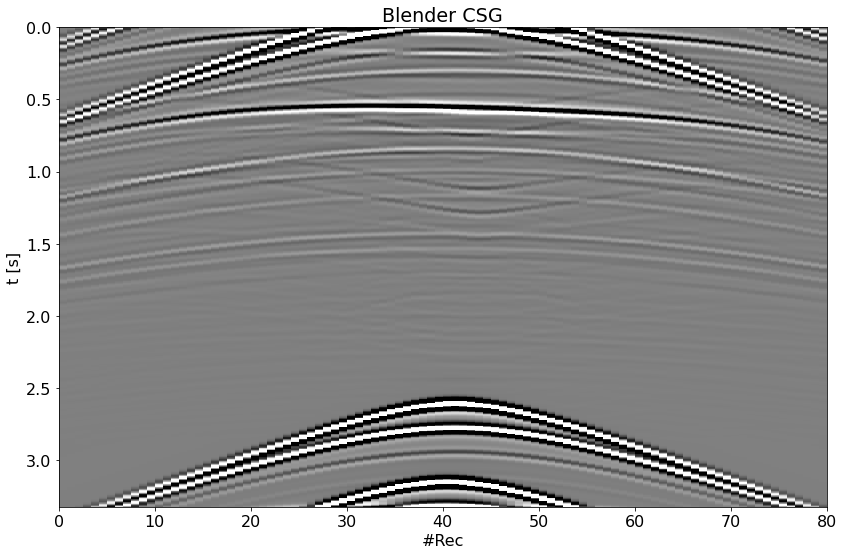

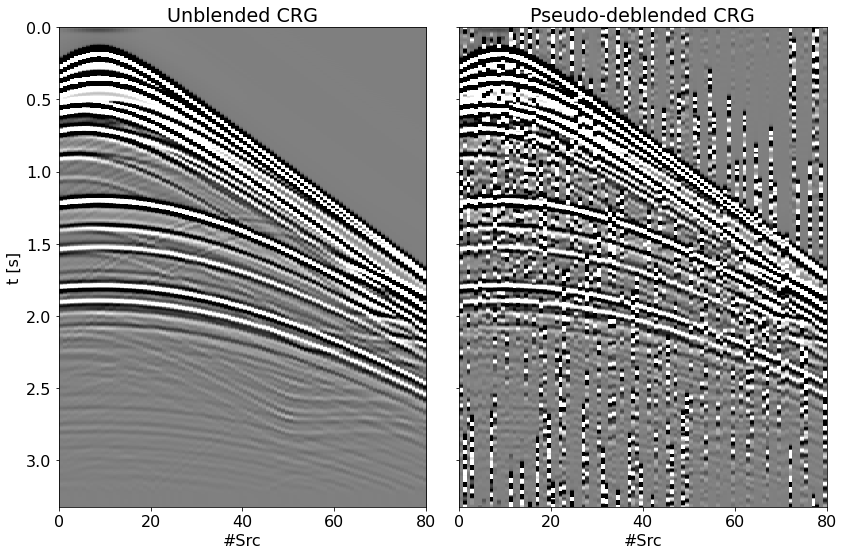

In [11]:
group_size = 2
n_groups = ns_obc // 2
#ignition_times = 0.4 * np.ones(ns_obc)
#ignition_times[::2] = 0.
ignition_times = np.abs(np.random.normal(0.5, 1., ns_obc)) # only positive shifts
ignition_times[0] = 0.

# Blending
Bop = BlendingGroup(nt, nr_obc, ns_obc, dt, ignition_times.reshape(group_size, n_groups), 
                    group_size=group_size, n_groups=n_groups, 
                    dtype="complex128")
dottest(Bop, verb=True)
data_blended = Bop * data_obc
data_pseudo = Bop.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(data_blended[n_groups//2].real.T, cmap="gray",
          vmin=-.1, vmax=.1,
          extent=(0, ns_stremer, t[-1], 0),
          interpolation="none")
ax.set_title("Blender CSG")
ax.set_xlabel("#Rec")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 8))
axs[0].imshow(data_obc[:, 10].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[0].set_title("Unblended CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(data_pseudo[:, 10].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
plt.tight_layout()

Let's just blend one receiver

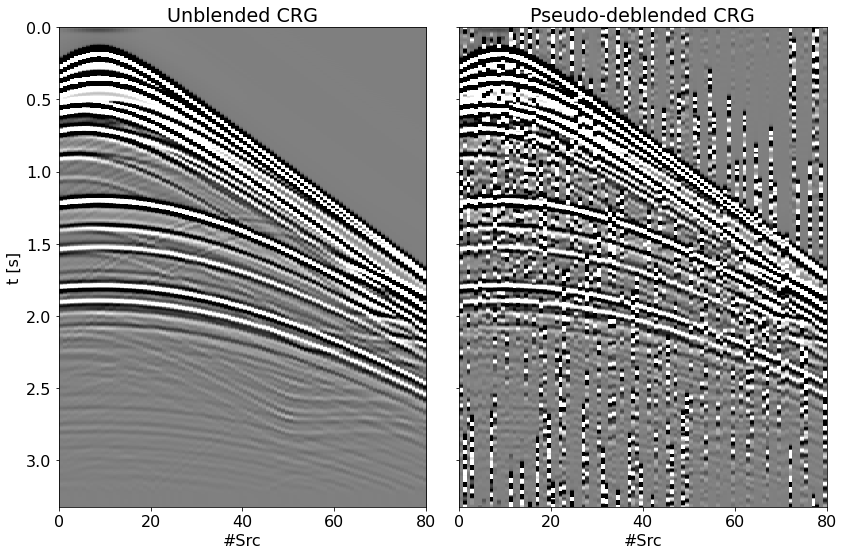

In [12]:
# Blending
Bop = BlendingGroup(nt, 1, ns_obc, dt, ignition_times.reshape(group_size, n_groups), 
                    group_size=group_size, n_groups=n_groups, dtype="complex128")
data_blended = Bop * data_obc[:, 10:11]
data_pseudo = Bop.H * data_blended

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 8))
axs[0].imshow(data_obc[:, 10].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[0].set_title("Unblended CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(data_pseudo.squeeze().real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
plt.tight_layout()

  910  975 1040], end:[  65  130  195  260  325  390  455  520  585  650  715  780  845  910
  975 1040 1105]


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 39936 rows and 707200 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 200
alpha = 4.198657e-01	thresh = 2.099328e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   2.00e-02+0.00e+00j    9.791e+00   1.803e+01   5.901e+00
     2   2.51e-02+0.00e+00j    2.939e+00   1.349e+01   1.849e+00
     3   2.60e-02+0.00e+00j    1.101e+00   1.255e+01   1.032e+00
     4   2.47e-02+0.00e+00j    5.802e-01   1.213e+01   6.410e-01
     5   2.23e-02+0.00e+00j    4.132e-01   1.170e+01   4.997e-01
     6   1.95e-02+0.00e+00j    3.478e-01   1.127e+01   4.549e-01
     7   1.64e-02+0.00e+00j    3.123e-01   1.087e+01   4.350e-01
     8   1.32e-02+0.00e+00j    2.855e-01   1.053e+01   4.194e-01
     9   1.00e-02+0.00e+00j    2.616e-01   1.023e+01   4.048e-01
    10   6.92e-03+0.00

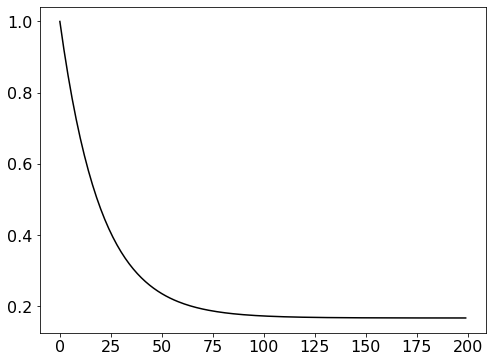

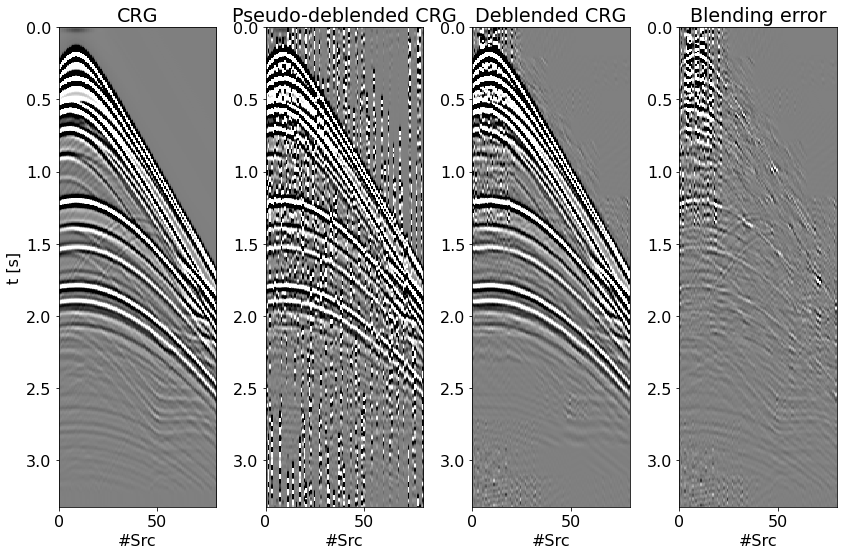

In [13]:
# Deblending
dimsd = (ns_obc, nt)
nwin = (32, 64)
nover = (16, 16)
nop = (128, 128)
nop1 = (128, 65)

Fop = FFT2D(nwin, nffts=nop, real=True)
nwins, dims, _, _ = patch2d_design(dimsd, nwin, nover, nop1)
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning")
Sop1 = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1, tapertype=None)

# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 200
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2
plt.figure()
plt.plot(decay, 'k')

p_inv = fista(
    Op,
    data_blended.ravel(),
    niter=niter,
    eps=1e-2,
    alpha=alpha,
    decay=decay,
    show=True,
)[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns_obc, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(data_obc[:, 10].T.real,
              cmap="gray", vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(data_pseudo.squeeze().T.real,
              cmap="gray", vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(data_inv.T.real,
              cmap="gray", vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(data_obc[:, 10].T.real - data_inv.T.real,
              cmap="gray", vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

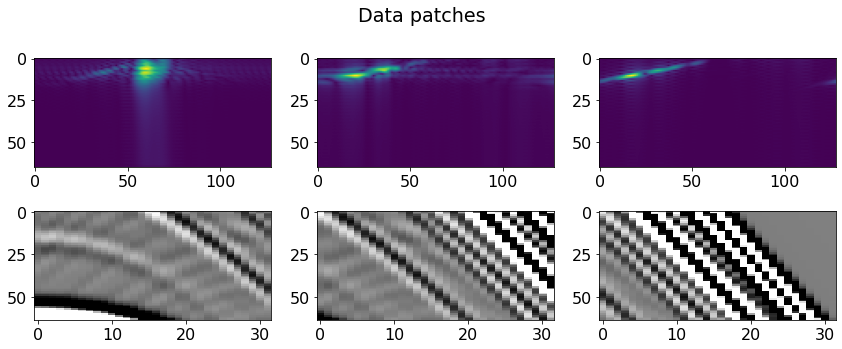

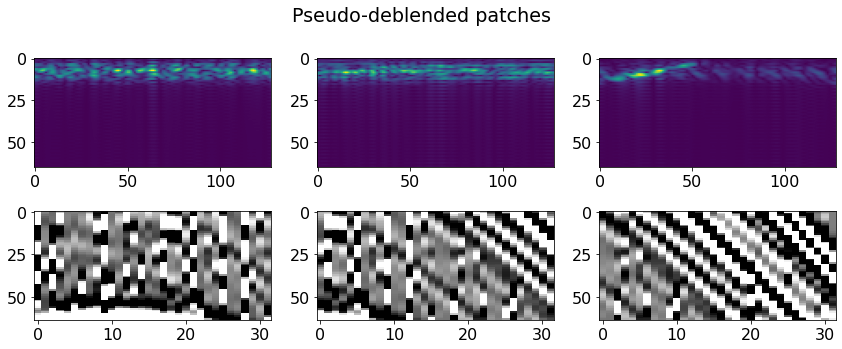

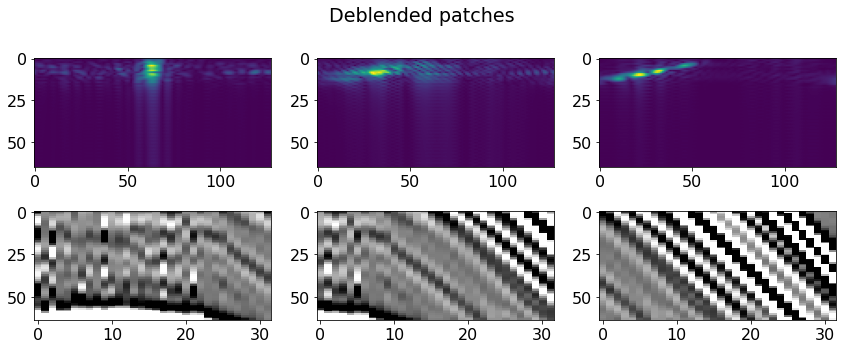

In [14]:
# Original
p = Sop1.H * data_obc[:, 0].ravel()
preshape = p.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

it = 5
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Data patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(preshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * preshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Pseudo-deblended
p_pseudo = Sop1.H * data_pseudo.ravel()
p_pseudoreshape = p_pseudo.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Pseudo-deblended patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_pseudoreshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_pseudoreshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Deblended
p_inv = Sop1.H * data_inv.ravel()
p_invreshape = p_inv.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Deblended patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_invreshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_invreshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

## Group blending with 3 sources

Dot test passed, v^H(Opu)=(-1711.457668763037+64.84539903412738j) - u^H(Op^Hv)=(-1711.4576687632339+64.84539903412528j)


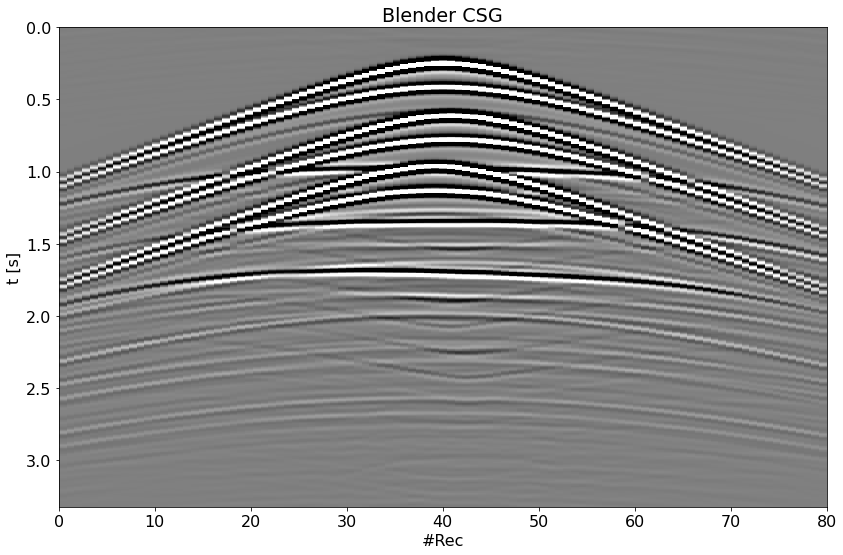

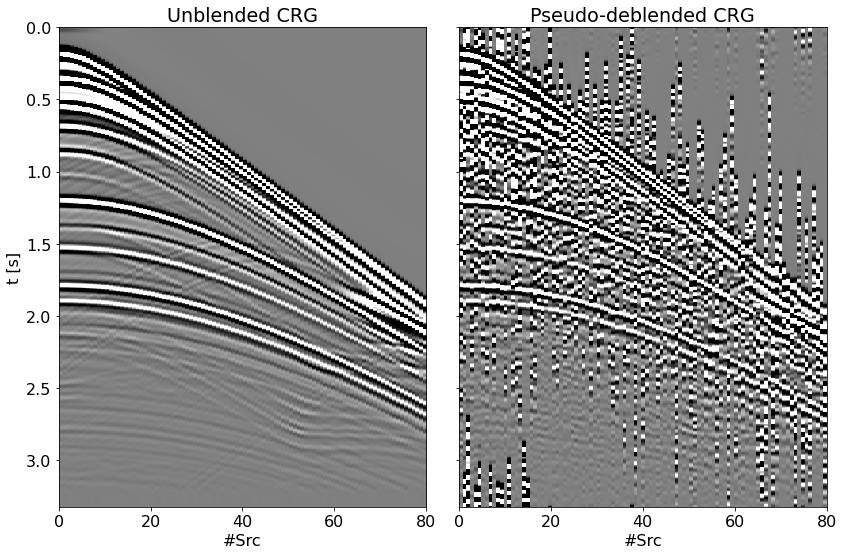

In [15]:
group_size = 3
n_groups = ns_obc3 // 3
ignition_times = np.abs(np.random.normal(0.2, 0.5, ns_obc3)) # only positive shifts
ignition_times[0] = 0.

# Blending
Bop = BlendingGroup(nt, nr_obc3, ns_obc3, dt, ignition_times.reshape(group_size, n_groups), 
                    group_size=group_size, n_groups=n_groups, 
                    dtype="complex128")
dottest(Bop, verb=True)
data_blended = Bop * data_obc3
data_pseudo = Bop.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(data_blended[n_groups//2].real.T, cmap="gray",
          vmin=-.1, vmax=.1,
          extent=(0, ns_stremer, t[-1], 0),
          interpolation="none")
ax.set_title("Blender CSG")
ax.set_xlabel("#Rec")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 8))
axs[0].imshow(data_obc[:, 0].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[0].set_title("Unblended CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(data_pseudo[:, 0].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
plt.tight_layout()

## Half blending

Dot test passed, v^H(Opu)=(-1116.7360466940152-31.19940815570245j) - u^H(Op^Hv)=(-1116.736046693904-31.199408155702606j)


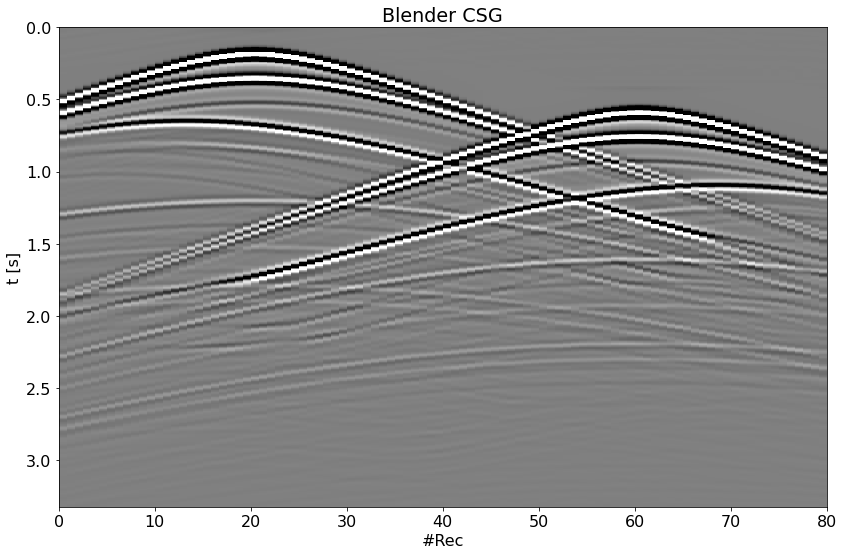

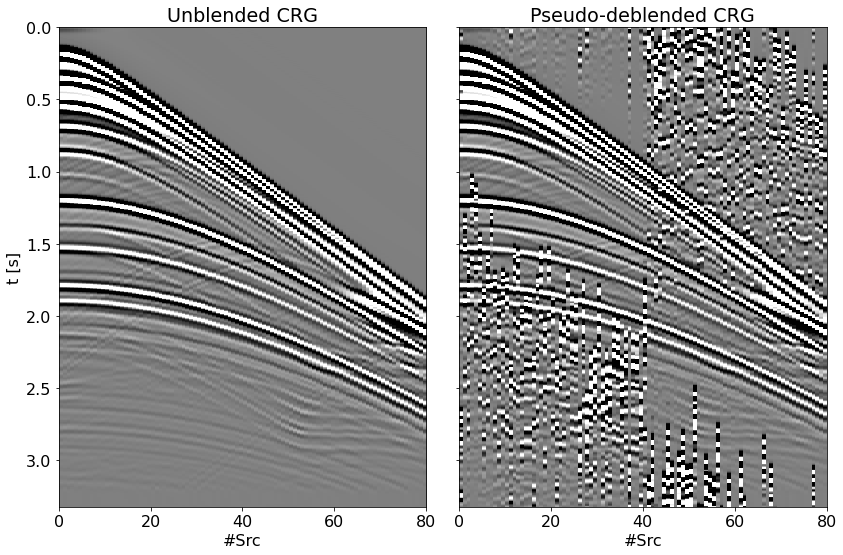

In [16]:
group_size = 2
n_groups = ns_obc // 2
ignition_times = np.abs(np.random.normal(.4, .4, (group_size, n_groups))) # only positive shifts
ignition_times[0] = 0.

# Blending
Bop = BlendingHalf(nt, nr_obc, ns_obc, dt, ignition_times.reshape(group_size, n_groups),
                   group_size=group_size, n_groups=n_groups, 
                   dtype="complex128", name=None)
dottest(Bop, verb=True)
#describe(Bop)

Bop.dims = (ns_obc, nr_obc, nt)
Bop.dimsd = (n_groups, nr_obc, nt)
data_blended = Bop * data_obc
data_pseudo = Bop.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(data_blended[n_groups//2].real.T, cmap="gray",
          vmin=-.1, vmax=.1,
          extent=(0, ns_stremer, t[-1], 0),
          interpolation="none")
ax.set_title("Blender CSG")
ax.set_xlabel("#Rec")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 8))
axs[0].imshow(data_obc[:, 0].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[0].set_title("Unblended CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(data_pseudo[:, 0].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
plt.tight_layout()

Let's just blend one receiver

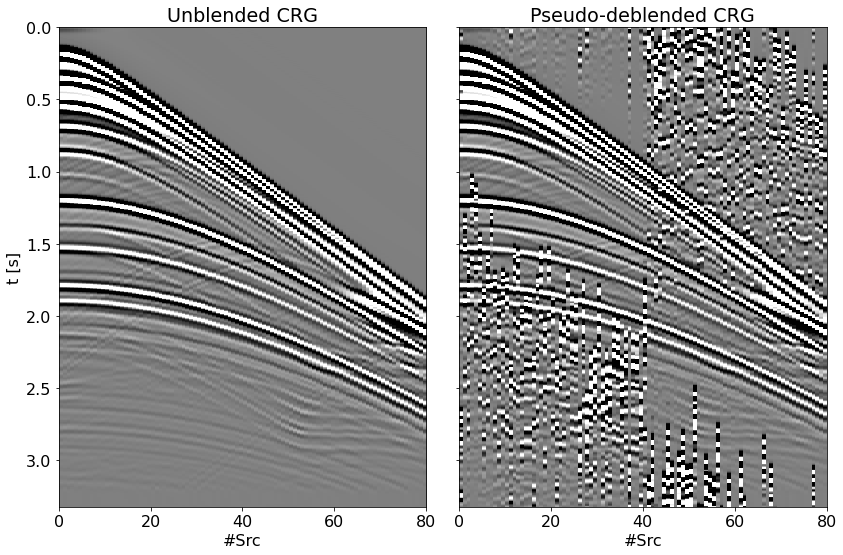

In [17]:
# Blending
Bop = BlendingHalf(nt, 1, ns_obc, dt, ignition_times.reshape(group_size, n_groups),
                   group_size=group_size, n_groups=n_groups, 
                   dtype="complex128", name=None)
data_blended = Bop * data_obc[:, 0].ravel()
data_pseudo = Bop.H * data_blended.ravel()
data_pseudo = data_pseudo.reshape(ns_obc, nt)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 8))
axs[0].imshow(data_obc[:, 0].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[0].set_title("Unblended CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(data_pseudo.real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
plt.tight_layout()

  910  975 1040], end:[  65  130  195  260  325  390  455  520  585  650  715  780  845  910
  975 1040 1105]


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 39936 rows and 707200 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 200
alpha = 3.249405e-01	thresh = 1.624703e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   1.10e-02+0.00e+00j    1.179e+01   1.672e+01   3.473e+00
     2   1.36e-02+0.00e+00j    4.273e+00   1.137e+01   1.669e+00
     3   1.36e-02+0.00e+00j    1.525e+00   9.880e+00   1.119e+00
     4   1.20e-02+0.00e+00j    6.721e-01   9.570e+00   6.844e-01
     5   1.01e-02+0.00e+00j    4.136e-01   9.402e+00   4.386e-01
     6   8.29e-03+0.00e+00j    3.257e-01   9.174e+00   3.475e-01
     7   6.85e-03+0.00e+00j    2.900e-01   8.909e+00   3.253e-01
     8   5.63e-03+0.00e+00j    2.698e-01   8.654e+00   3.174e-01
     9   4.62e-03+0.00e+00j    2.518e-01   8.427e+00   3.107e-01
    10   3.75e-03+0.00

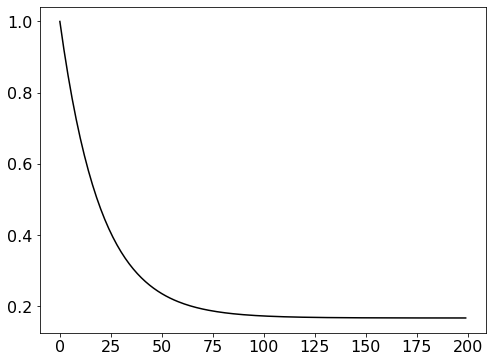

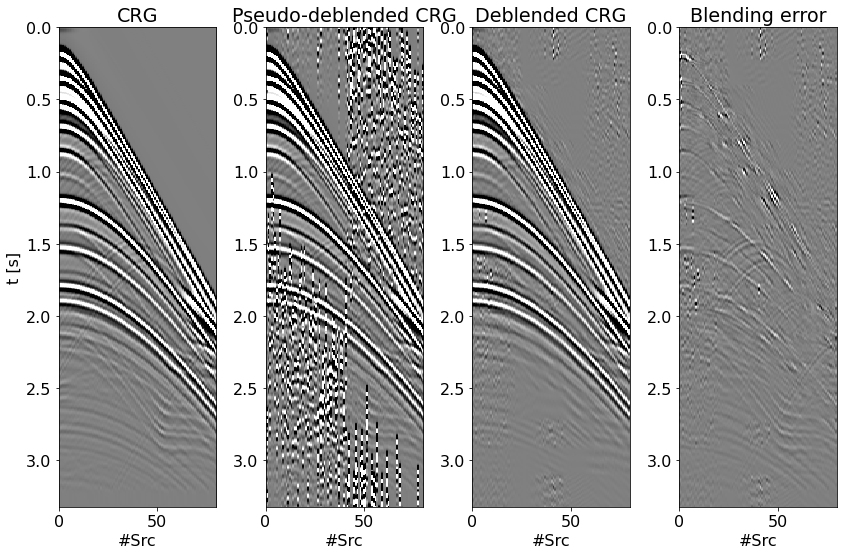

In [18]:
# Deblending
dimsd = (ns_obc, nt)
nwin = (32, 64)
nover = (16, 16)
nop = (128, 128)
nop1 = (128, 65)

Fop = FFT2D(nwin, nffts=nop, real=True)
nwins, dims, _, _ = patch2d_design(dimsd, nwin, nover, nop1)
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning")
Sop1 = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1, tapertype=None)

# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 200
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2
plt.figure()
plt.plot(decay, 'k')

#with pylops.disabled_ndarray_multiplication():
p_inv = fista(
    Op,
    data_blended.ravel(),
    niter=niter,
    eps=1e-2,
    alpha=alpha,
    decay=decay,
    show=True,
)[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns_obc, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(data_obc[:, 0].T.real,
              cmap="gray", vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(data_pseudo.T.real,
              cmap="gray", vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(data_inv.T.real,
              cmap="gray", vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(data_obc[:, 0].T.real - data_inv.T.real,
              cmap="gray", vmin=-.01, vmax=.01,
              extent=(0, ns_stremer, t[-1], 0),
              interpolation="none")
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

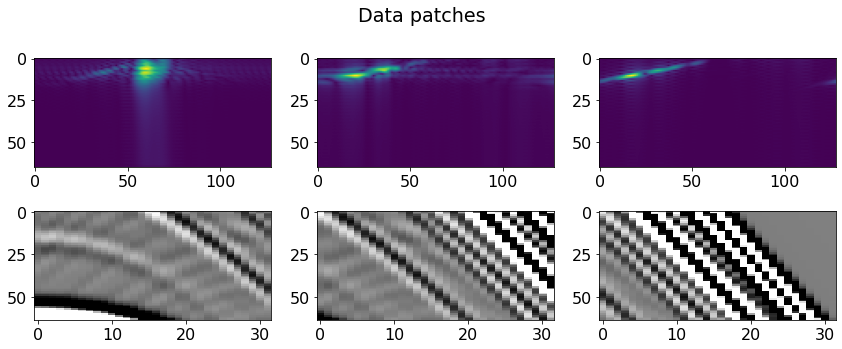

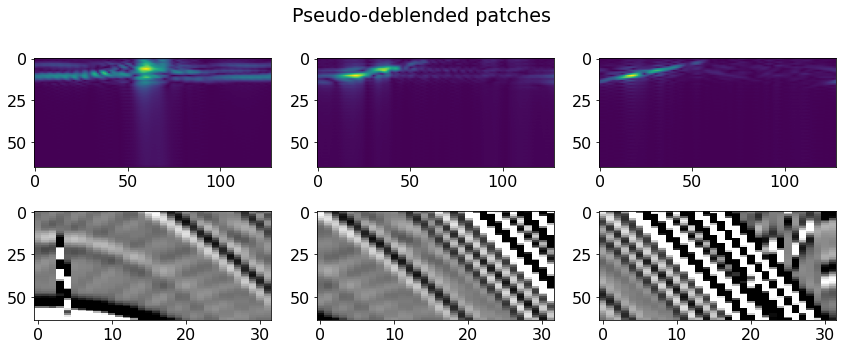

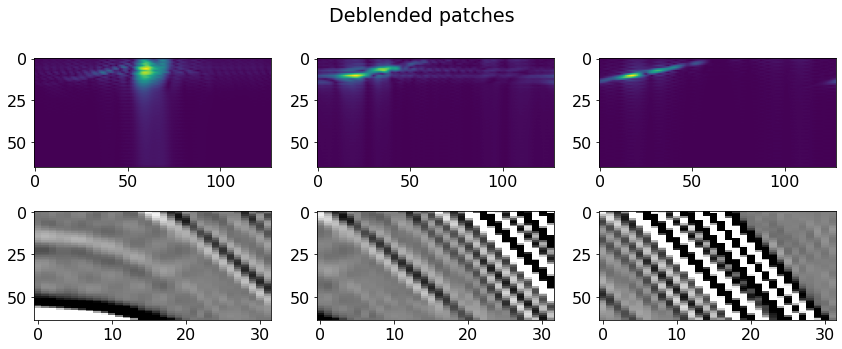

In [19]:
# Original
p = Sop1.H * data_obc[:, 0].ravel()
preshape = p.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

it = 5
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Data patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(preshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * preshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Pseudo-deblended
p_pseudo = Sop1.H * data_pseudo.ravel()
p_pseudoreshape = p_pseudo.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Pseudo-deblended patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_pseudoreshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_pseudoreshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Deblended
p_inv = Sop1.H * data_inv.ravel()
p_invreshape = p_inv.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Deblended patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_invreshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_invreshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

## Continuous+group blending

Here we consider a special case where we have 2 boats and each the shoots in continous manner. We can achieve this by simply using the continous strategy and twick the timings.

Dot test passed, v^H(Opu)=(3058.9996642279634+1.4421866261722655e-13j) - u^H(Op^Hv)=(3058.9996642279752+2.065086598331237e-13j)


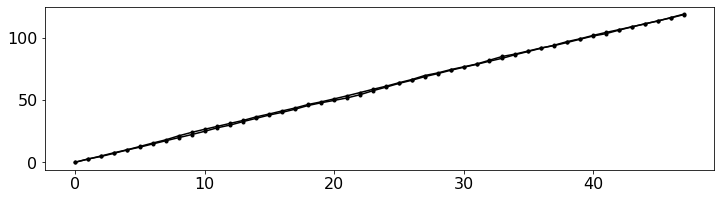

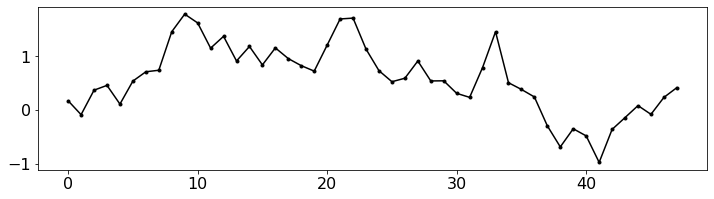

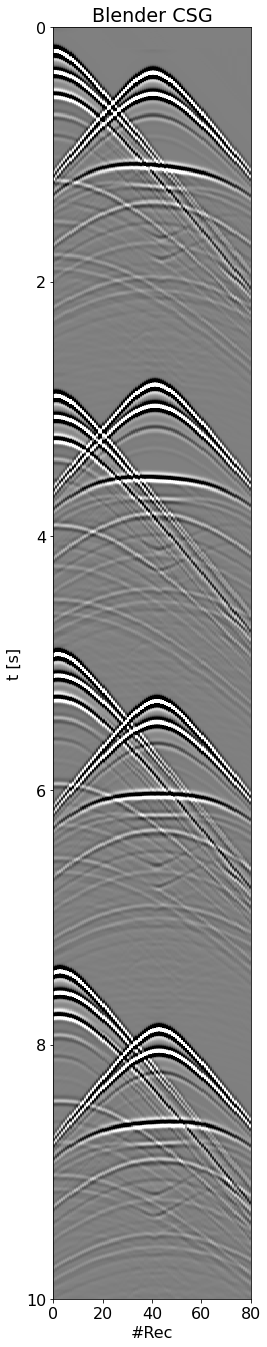

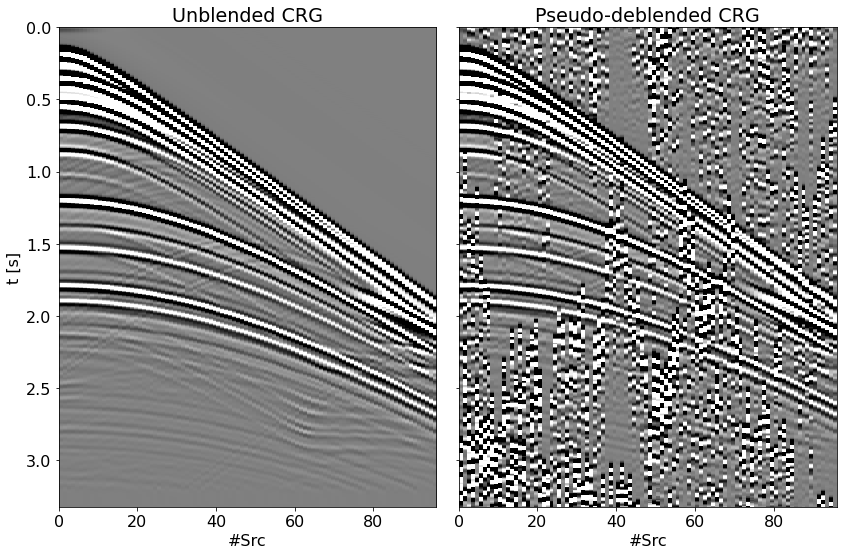

In [40]:
np.random.seed(10)
overlap = 0.25
ignition_times = np.random.normal(0, 0.3, ns_obc)
ignition_times[ns_obc//2] = ignition_times[ns_obc//2]
ignition_times += (1-overlap) * nt * dt
ignition_times[0] = 0.
ignition_times[ns_obc//2] -= (1-overlap) * nt * dt
ignition_times[:ns_obc//2] = np.cumsum(ignition_times[:ns_obc//2])
ignition_times[ns_obc//2:] = np.cumsum(ignition_times[ns_obc//2:])

plt.figure(figsize=(12, 3))
plt.plot(ignition_times[:ns_obc//2], ".-k")
plt.plot(ignition_times[ns_obc//2:], ".-k")

plt.figure(figsize=(12, 3))
plt.plot(ignition_times[ns_obc//2:]-ignition_times[:ns_obc//2], ".-k")

# Blending
Bop = BlendingContinuous(nt, nr_obc, ns_obc, dt, ignition_times, dtype="complex128")
dottest(Bop, verb=True)
data_blended = Bop * data_obc
data_pseudo = Bop.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(4, 19))
ax.imshow(data_blended.real.T, cmap="gray",
          vmin=-.1, vmax=.1,
          extent=(0, ns_stremer, Bop.nttot*dt, 0),
          interpolation="none")
ax.set_title("Blender CSG")
ax.set_xlabel("#Rec")
ax.set_ylabel("t [s]")
ax.axis("tight")
ax.set_ylim(10, 0)
plt.tight_layout()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 8))
axs[0].imshow(data_obc[:, 0].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_obc, t[-1], 0),
              interpolation="none")
axs[0].set_title("Unblended CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(data_pseudo[:, 0].real.T, cmap="gray",
              vmin=-.01, vmax=.01,
              extent=(0, ns_obc, t[-1], 0),
              interpolation="none")
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
plt.tight_layout()

  910  975 1040], end:[  65  130  195  260  325  390  455  520  585  650  715  780  845  910
  975 1040 1105]


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 30517 rows and 707200 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 100
alpha = 2.542137e-01	thresh = 1.271068e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   8.25e-03+0.00e+00j    8.442e+00   1.462e+01   3.369e+00
     2   9.19e-03+0.00e+00j    2.973e+00   1.114e+01   1.252e+00
     3   7.64e-03+0.00e+00j    1.192e+00   1.032e+01   7.739e-01
     4   4.90e-03+0.00e+00j    6.170e-01   1.005e+01   4.889e-01
     5   1.91e-03+0.00e+00j    4.100e-01   9.783e+00   3.649e-01
     6   0.00e+00+0.00e+00j    3.257e-01   9.490e+00   3.208e-01
     7   -5.43e-05+6.65e-21j    2.845e-01   9.200e+00   3.025e-01
     8   -0.00e+00+0.00e+00j    2.579e-01   8.933e+00   2.924e-01
     9   0.00e+00-0.00e+00j    2.360e-01   8.694e+00   2.843e-01
    10   -0.00e+00+0

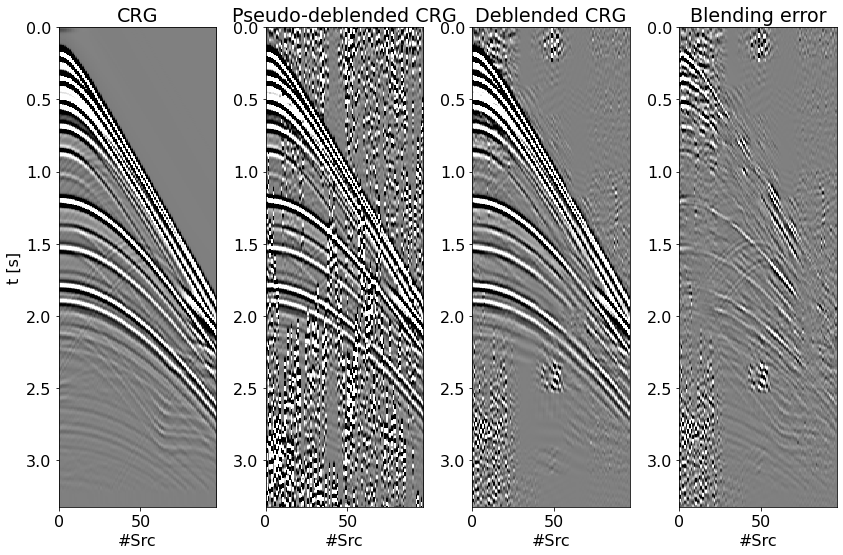

In [41]:
# Deblending
dimsd = (ns_obc, nt)
nwin = (32, 64)
nover = (16, 16)
nop = (128, 128)
nop1 = (128, 65)

Fop = FFT2D(nwin, nffts=nop, real=True)
nwins, dims, _, _ = patch2d_design(dimsd, nwin, nover, nop1)
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning")
Sop1 = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop1, tapertype=None)
Bop = BlendingContinuous(nt, 1, ns_obc, dt, ignition_times, dtype="complex128")

# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 100
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

p_inv = fista(
    Op,
    data_blended[0],
    niter=niter,
    eps=1e-2,
    alpha=alpha,
    decay=decay,
    show=True,
)[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns_obc, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(
    data_obc[:, 0].T.real,
    cmap="gray",
    extent=(0, ns_obc, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(
    data_pseudo[:, 0].T.real,
    cmap="gray",
    extent=(0, ns_obc, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(
    data_inv.T.real,
    cmap="gray",
    extent=(0, ns_obc, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(
    data_obc[:, 0].T.real - data_inv.T.real,
    cmap="gray",
    extent=(0, ns_obc, t[-1], 0),
    vmin=-.01, vmax=.01,
    interpolation="none",
)
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

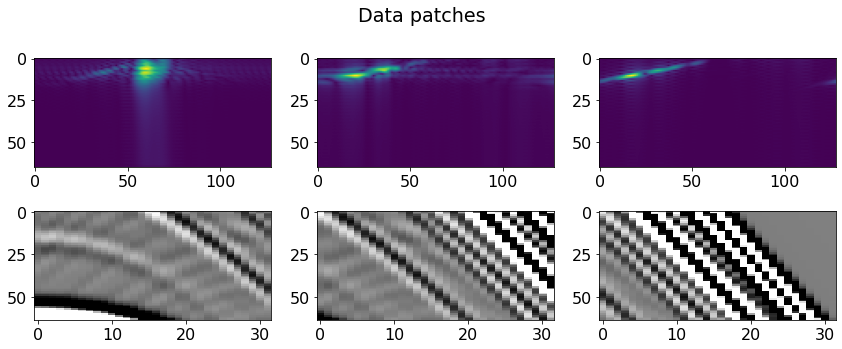

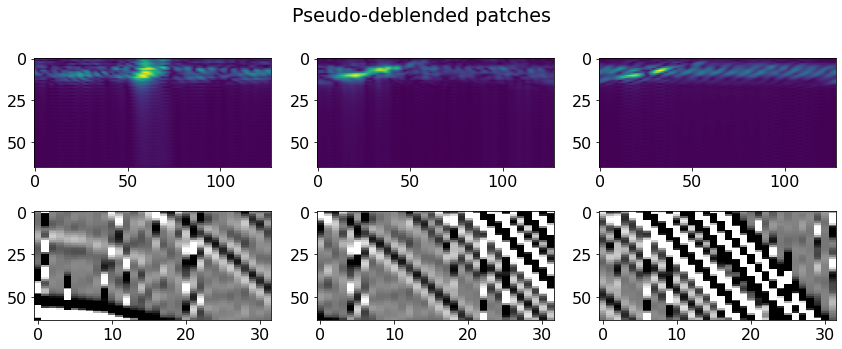

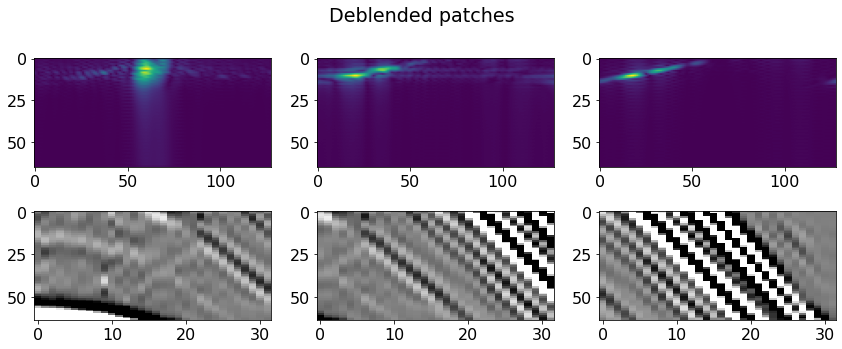

In [42]:
# Original
p = Sop1.H * data_obc[:, 0].ravel()
preshape = p.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

it = 5
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Data patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(preshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * preshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Pseudo-deblended
p_pseudo = Sop1.H * data_pseudo[:, 0].ravel()
p_pseudoreshape = p_pseudo.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Pseudo-deblended patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_pseudoreshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_pseudoreshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Deblended
p_inv = Sop1.H * data_inv.ravel()
p_invreshape = p_inv.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
fig.suptitle("Deblended patches")
for i in range(3):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_invreshape[i, it]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_invreshape[i, it].ravel()).reshape(nwin)).T,
        cmap="gray", vmin=-.01, vmax=.01,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()